# SETUP

In [1]:
%%bash
pip install --upgrade pip tensorflow keras &> pip.log
pip install jupyterlab-vim openpyxl pydot >> pip.log
#pip isntall 'tensorflow[and-cuda]' >> pip.log
apt-get install graphviz -y &> apt.log

## Libraries

In [2]:
# System
import os
import glob
import shutil
import copy
import re
from datetime import datetime
import logging

# Data
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Data processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Model
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from keras import Input, Model, Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, GRU, Conv1D, MaxPooling1D, Flatten
from keras.utils import plot_model
from keras.saving import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from keras.losses import MeanAbsoluteError, MeanSquaredError
import keras.backend as K

# Custom libraries written by myself
from src.drawing.plot import plot_1_data, plot_2_data
from src.prediction_model.lstm import predictLSTM, evaluateLSTM
from src.reduction_model.lstm_s2s import LSTMSeq2SeqReduction
from src.reduction_model.gru_s2s import GRUSeq2SeqReduction
from src.reduction_model.cnnlstm_s2s import CNNLSTMSeq2SeqReduction
from src.prediction_model.lstm import predictLSTM, evaluateLSTM

# Configuration reader
from src.config_reader.config_reader import ConfigurationReader

# Checking Tensorflow
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices('CPU'))

E0000 00:00:1751706252.273363 2854501 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751706252.279699 2854501 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751706252.295541 2854501 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751706252.295562 2854501 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751706252.295564 2854501 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751706252.295566 2854501 computation_placer.cc:177] computation placer already registered. Please check linka

2.19.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Configuration

In [3]:
confReader = ConfigurationReader("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/model_params.json")
print(confReader)

conf = confReader.data
print(conf)

# Clear all temp folders
def cleanDir(input_dir):
    if os.path.exists(input_dir):
        shutil.rmtree(input_dir)
    os.makedirs(input_dir)

cleanDir(conf["workspace"]["model_info_dir"])
cleanDir(conf["workspace"]["model_checkpoints_dir"])
cleanDir(conf["workspace"]["data_statistic_dir"])
cleanDir(conf["workspace"]["data_by_station_dir"])

{
    "dataset": {
        "matchingdata2022": {
            "file_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MatchingData2022.xlsx"
        },
        "mpair": {
            "file_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MPair.csv",
            "target_start_date": "2021-01-01",
            "target_end_date": "2022-12-31"
        }
    },
    "workspace": {
        "model_info_dir": "/le_thanh_van_118/workspace/hiep_workspace/model_info",
        "model_checkpoints_dir": "/le_thanh_van_118/workspace/hiep_workspace/model_checkpoints",
        "data_by_location_dir": "/le_thanh_van_118/workspace/hiep_workspace/data_by_location",
        "data_by_station_dir": "/le_thanh_van_118/workspace/hiep_workspace/data_by_station",
        "data_statistic_dir": "/le_thanh_van_118/workspace/hiep_workspace/data_statistic"
    },
    "prediction": {
        "n_past": 7,
        "n_future": 1,
        "epochs": 20,
    

# AOD 2022 DATA

## Load dataset

### Raw data

In [4]:
df_aod_raw = pd.read_excel(conf["dataset"]["matchingdata2022"]["file_dir"])
df_aod_raw

,time,ID,pm25,lat,lon,PM25_3km,TMP,RH,HPBL,WSPD,...,PRIM_ROAD_LEN_1km,NEAR_DIST,BARELAND,BUILTUP,CROPLAND,GRASSLAND,TREECOVER,WATER,NDVI,Name
0,2022-01-01,S4,23.768238,10.815839,106.717396,22.025597,28.261583,57.233841,721.996887,2.003031,...,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486,"Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn..."
1,2022-01-01,S5,14.221014,10.776415,106.687955,22.705284,27.787918,61.073841,659.863586,1.885687,...,7249.776367,21.703104,395.082094,877872.4121,0.00000,98.770523,121487.74380,0.00000,1721.431568,Tòa soạn Báo Thanh Niên - Nguyễn Đình Chiểu - Q3
2,2022-01-01,S6,21.405015,10.780482,106.659511,23.503082,27.787918,61.073841,659.863586,1.885687,...,2345.868408,6.057246,10370.904960,885181.4309,0.00000,8099.182920,95807.40771,0.00000,1879.344348,"MobiFone Thành Thái, Q10"
3,2022-01-01,S7,21.695652,10.783456,106.700622,22.705284,27.787918,61.073841,659.863586,1.885687,...,6885.987305,18.537305,296.311570,764977.7039,0.00000,1876.639945,232011.95950,0.00000,2700.122924,ĐSQ Mỹ
4,2022-01-02,S4,22.154723,10.815839,106.717396,22.711113,25.827082,57.916595,619.779785,1.286289,...,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486,"Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,2022-12-30,S6,33.091428,10.780482,106.659511,19.854403,24.979719,64.868401,680.533081,3.893373,...,2345.868408,6.057246,10370.904960,885181.4309,0.00000,8099.182920,95807.40771,0.00000,1879.344348,"MobiFone Thành Thái, Q10"
994,2022-12-30,S7,40.166667,10.783456,106.700622,19.137615,24.979719,64.868401,680.533081,3.893373,...,6885.987305,18.537305,296.311570,764977.7039,0.00000,1876.639945,232011.95950,0.00000,2700.122924,ĐSQ Mỹ
995,2022-12-31,S4,27.879261,10.815839,106.717396,28.223820,26.630608,55.437901,607.372803,4.217750,...,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486,"Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn..."
996,2022-12-31,S6,28.854069,10.780482,106.659511,27.658358,25.364861,62.377899,799.122803,4.161542,...,2345.868408,6.057246,10370.904960,885181.4309,0.00000,8099.182920,95807.40771,0.00000,1879.344348,"MobiFone Thành Thái, Q10"


In [5]:
df_aod_raw.columns

Index(['time', 'ID', 'pm25', 'lat', 'lon', 'PM25_3km', 'TMP', 'RH', 'HPBL',
       'WSPD', 'PRES2M', 'AOD', 'OID', 'POP', 'ROAD_DEN_1km',
       'PRIM_ROAD_LEN_1km', 'NEAR_DIST', 'BARELAND', 'BUILTUP', 'CROPLAND',
       'GRASSLAND', 'TREECOVER', 'WATER', 'NDVI', 'Name'],
      dtype='object')

### Statistics

In [6]:
df_aod_stat = df_aod_raw.describe()
df_aod_stat.to_csv(f'{conf["workspace"]["data_statistic_dir"]}/df_aod_stat.csv')

In [7]:
df_aod_raw.isnull().sum()

time                   0
ID                     0
pm25                   0
lat                    0
lon                    0
PM25_3km               0
TMP                    0
RH                     0
HPBL                   0
WSPD                   0
PRES2M                 0
AOD                  844
OID                    0
POP                    0
ROAD_DEN_1km           0
PRIM_ROAD_LEN_1km      0
NEAR_DIST              0
BARELAND               0
BUILTUP                0
CROPLAND               0
GRASSLAND              0
TREECOVER              0
WATER                  0
NDVI                   0
Name                   0
dtype: int64

### Drop unnecessary columns

In [8]:
# The AIMODEL is not necessary for prediction, let's remove it
df_aod_raw.drop(["PM25_3km", "Name", "ID"], axis=1, inplace=True)
df_aod_raw

,time,pm25,lat,lon,TMP,RH,HPBL,WSPD,PRES2M,AOD,...,ROAD_DEN_1km,PRIM_ROAD_LEN_1km,NEAR_DIST,BARELAND,BUILTUP,CROPLAND,GRASSLAND,TREECOVER,WATER,NDVI
0,2022-01-01,23.768238,10.815839,106.717396,28.261583,57.233841,721.996887,2.003031,101227.000000,0.338000,...,22.923040,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486
1,2022-01-01,14.221014,10.776415,106.687955,27.787918,61.073841,659.863586,1.885687,101204.875000,0.118424,...,23.362053,7249.776367,21.703104,395.082094,877872.4121,0.00000,98.770523,121487.74380,0.00000,1721.431568
2,2022-01-01,21.405015,10.780482,106.659511,27.787918,61.073841,659.863586,1.885687,101204.875000,0.128542,...,33.629780,2345.868408,6.057246,10370.904960,885181.4309,0.00000,8099.182920,95807.40771,0.00000,1879.344348
3,2022-01-01,21.695652,10.783456,106.700622,27.787918,61.073841,659.863586,1.885687,101204.875000,0.118424,...,27.462461,6885.987305,18.537305,296.311570,764977.7039,0.00000,1876.639945,232011.95950,0.00000,2700.122924
4,2022-01-02,22.154723,10.815839,106.717396,25.827082,57.916595,619.779785,1.286289,101201.015625,NaN,...,22.923040,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,2022-12-30,33.091428,10.780482,106.659511,24.979719,64.868401,680.533081,3.893373,101393.398438,NaN,...,33.629780,2345.868408,6.057246,10370.904960,885181.4309,0.00000,8099.182920,95807.40771,0.00000,1879.344348
994,2022-12-30,40.166667,10.783456,106.700622,24.979719,64.868401,680.533081,3.893373,101393.398438,NaN,...,27.462461,6885.987305,18.537305,296.311570,764977.7039,0.00000,1876.639945,232011.95950,0.00000,2700.122924
995,2022-12-31,27.879261,10.815839,106.717396,26.630608,55.437901,607.372803,4.217750,101322.437500,NaN,...,22.923040,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486
996,2022-12-31,28.854069,10.780482,106.659511,25.364861,62.377899,799.122803,4.161542,101297.140625,NaN,...,33.629780,2345.868408,6.057246,10370.904960,885181.4309,0.00000,8099.182920,95807.40771,0.00000,1879.344348


### Handle metadata

In [9]:
# Convert "time" columns to Pandas datetime
df_aod_raw = df_aod_raw.assign(time=pd.to_datetime(df_aod_raw["time"]))

# Set "time" column as index
df_aod_raw.set_index("time", inplace=True)

# Lower case all column names
df_aod_raw = df_aod_raw.rename(columns={name: name.lower() for name in df_aod_raw.columns})

# Rename oid to station
df_aod_raw = df_aod_raw.rename(columns={"oid": "station"})

# Print
df_aod_raw

,pm25,lat,lon,tmp,rh,hpbl,wspd,pres2m,aod,station,...,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi
time,,,,,,,,,,,,,,,,,,,,,
2022-01-01,23.768238,10.815839,106.717396,28.261583,57.233841,721.996887,2.003031,101227.000000,0.338000,214,...,22.923040,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486
2022-01-01,14.221014,10.776415,106.687955,27.787918,61.073841,659.863586,1.885687,101204.875000,0.118424,215,...,23.362053,7249.776367,21.703104,395.082094,877872.4121,0.00000,98.770523,121487.74380,0.00000,1721.431568
2022-01-01,21.405015,10.780482,106.659511,27.787918,61.073841,659.863586,1.885687,101204.875000,0.128542,216,...,33.629780,2345.868408,6.057246,10370.904960,885181.4309,0.00000,8099.182920,95807.40771,0.00000,1879.344348
2022-01-01,21.695652,10.783456,106.700622,27.787918,61.073841,659.863586,1.885687,101204.875000,0.118424,201,...,27.462461,6885.987305,18.537305,296.311570,764977.7039,0.00000,1876.639945,232011.95950,0.00000,2700.122924
2022-01-02,22.154723,10.815839,106.717396,25.827082,57.916595,619.779785,1.286289,101201.015625,NaN,214,...,22.923040,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-30,33.091428,10.780482,106.659511,24.979719,64.868401,680.533081,3.893373,101393.398438,NaN,216,...,33.629780,2345.868408,6.057246,10370.904960,885181.4309,0.00000,8099.182920,95807.40771,0.00000,1879.344348
2022-12-30,40.166667,10.783456,106.700622,24.979719,64.868401,680.533081,3.893373,101393.398438,NaN,201,...,27.462461,6885.987305,18.537305,296.311570,764977.7039,0.00000,1876.639945,232011.95950,0.00000,2700.122924
2022-12-31,27.879261,10.815839,106.717396,26.630608,55.437901,607.372803,4.217750,101322.437500,NaN,214,...,22.923040,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486


### Define label, static features and dynamic features

In [10]:
aod_label = ["pm25"]
aod_index = ["time"]
aod_stat_feats = ['lat', 'lon', 'station', 'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist', \
                  'bareland', 'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi']
aod_dyn_feats = list(set(df_aod_raw.columns) - set(aod_stat_feats) - set(aod_label) - set(aod_index))
aod_all_stations = sorted(df_aod_raw["station"].unique())

print(f'aod_label = {aod_label}\naod_stat_feats = {aod_stat_feats}\naod_dyn_feats = {aod_dyn_feats}\naod_all_stations = {aod_all_stations}')

aod_label = ['pm25']
aod_stat_feats = ['lat', 'lon', 'station', 'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist', 'bareland', 'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi']
aod_dyn_feats = ['tmp', 'pres2m', 'hpbl', 'aod', 'wspd', 'rh']
aod_all_stations = [201, 214, 215, 216]


### Data preparation

In [11]:
all_valid_stations_df = []
numerical_columns = df_aod_raw.columns[5:]

for station in aod_all_stations:
    # Get dataframe of current location i, j
    df_aod_current_station = df_aod_raw[df_aod_raw["station"] == station]

    # Fill aod column
    df_aod_current_station.loc[:, "aod"] = df_aod_current_station.loc[:, "aod"].fillna(df_aod_current_station.loc[:, "aod"].mean())

    # Store file for debugging after filling missing values
    df_aod_current_station.to_csv(f"{conf['workspace']['data_by_station_dir']}/df_aod_{station}.csv", index=True)

    # Reappend the location to dataset
    all_valid_stations_df.append(df_aod_current_station)

# This will group the data by location (i, j) then by date
df_aod_raw = pd.concat(all_valid_stations_df)
df_aod_raw

,pm25,lat,lon,tmp,rh,hpbl,wspd,pres2m,aod,station,...,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi
time,,,,,,,,,,,,,,,,,,,,,
2022-01-01,21.695652,10.783456,106.700622,27.787918,61.073841,659.863586,1.885687,101204.875000,0.118424,201,...,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924
2022-01-02,24.583333,10.783456,106.700622,24.707085,65.996597,432.379822,1.432167,101180.710938,0.431278,201,...,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924
2022-01-03,31.083333,10.783456,106.700622,26.576595,66.171082,443.947327,1.533191,101102.156250,0.431278,201,...,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924
2022-01-04,50.916667,10.783456,106.700622,26.506687,76.320465,432.340332,1.721378,101116.687500,0.431278,201,...,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924
2022-01-05,33.041667,10.783456,106.700622,26.590250,79.178970,459.642944,1.762114,101090.539062,0.431278,201,...,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,39.659816,10.780482,106.659511,24.136936,73.973083,457.798645,2.002987,101322.195312,0.462378,216,...,33.629780,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348
2022-12-28,44.679352,10.780482,106.659511,25.844296,65.530487,644.974548,2.298220,101305.984375,0.462378,216,...,33.629780,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348
2022-12-29,30.724708,10.780482,106.659511,25.841156,67.093735,825.517395,2.823764,101330.093750,0.191691,216,...,33.629780,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348


## Preprocessing

In [12]:
df_aod = copy.deepcopy(df_aod_raw)

### Extract columns: time

In [13]:
# Get the time indices
aod_time_indices = df_aod.index
aod_time_indices

DatetimeIndex(['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04',
               '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
               '2022-01-09', '2022-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', name='time', length=998, freq=None)

### Split into features and labels
* Label: pm25_3km
* Features: other columns
    * Dynamic features
    * Static features

In [14]:
X_aod = df_aod.loc[:, aod_stat_feats + aod_dyn_feats]
y_aod = df_aod.loc[:, aod_label]

In [15]:
X_aod

,lat,lon,station,pop,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,tmp,pres2m,hpbl,aod,wspd,rh
time,,,,,,,,,,,,,,,,,,,,
2022-01-01,10.783456,106.700622,201,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,27.787918,101204.875000,659.863586,0.118424,1.885687,61.073841
2022-01-02,10.783456,106.700622,201,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,24.707085,101180.710938,432.379822,0.431278,1.432167,65.996597
2022-01-03,10.783456,106.700622,201,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,26.576595,101102.156250,443.947327,0.431278,1.533191,66.171082
2022-01-04,10.783456,106.700622,201,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,26.506687,101116.687500,432.340332,0.431278,1.721378,76.320465
2022-01-05,10.783456,106.700622,201,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,26.590250,101090.539062,459.642944,0.431278,1.762114,79.178970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,10.780482,106.659511,216,57523.91406,33.629780,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,24.136936,101322.195312,457.798645,0.462378,2.002987,73.973083
2022-12-28,10.780482,106.659511,216,57523.91406,33.629780,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,25.844296,101305.984375,644.974548,0.462378,2.298220,65.530487
2022-12-29,10.780482,106.659511,216,57523.91406,33.629780,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,25.841156,101330.093750,825.517395,0.191691,2.823764,67.093735


In [16]:
y_aod

,pm25
time,
2022-01-01,21.695652
2022-01-02,24.583333
2022-01-03,31.083333
2022-01-04,50.916667
2022-01-05,33.041667
...,...
2022-12-27,39.659816
2022-12-28,44.679352
2022-12-29,30.724708


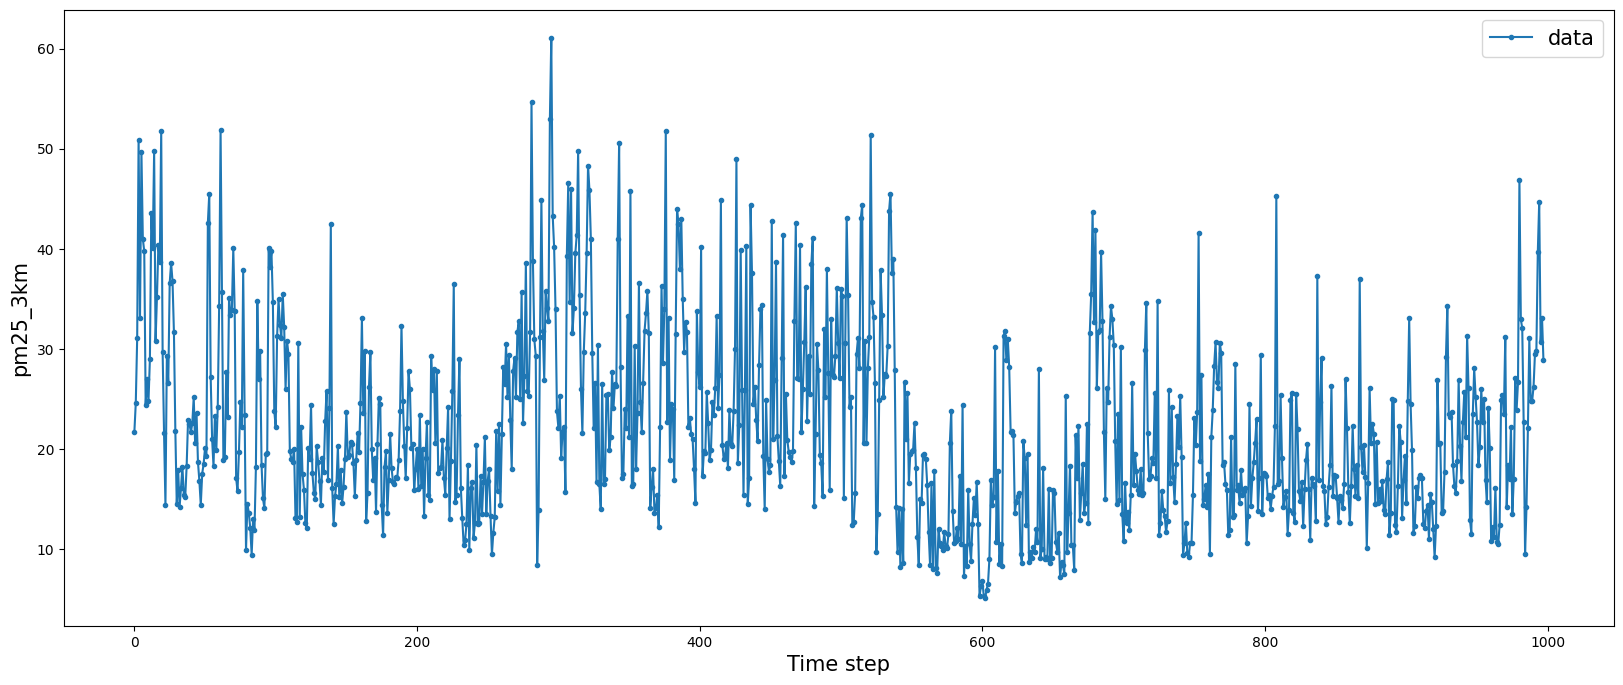

In [17]:
plot_1_data(data=y_aod, datalabel="data", xlabel="Time step", ylabel="pm25_3km")

### Data normalization

In [18]:
aod_features_scaler = MinMaxScaler()
X_aod_scaled = aod_features_scaler.fit_transform(X_aod)
X_aod_scaled = pd.DataFrame(X_aod_scaled, columns=X_aod.columns)
X_aod_scaled

,lat,lon,station,pop,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,tmp,pres2m,hpbl,aod,wspd,rh
0,0.178597,0.710219,0.0,0.029265,0.423978,0.926097,0.834737,0.0,0.0,0.0,0.222222,1.000000,0.0,1.000000,0.401276,0.832575,0.457426,0.004414,0.151021,0.276706
1,0.178597,0.710219,0.0,0.029265,0.423978,0.926097,0.834737,0.0,0.0,0.0,0.222222,1.000000,0.0,1.000000,0.062664,0.813284,0.283063,0.125220,0.061050,0.387859
2,0.178597,0.710219,0.0,0.029265,0.423978,0.926097,0.834737,0.0,0.0,0.0,0.222222,1.000000,0.0,1.000000,0.268140,0.750574,0.291929,0.125220,0.081091,0.391799
3,0.178597,0.710219,0.0,0.029265,0.423978,0.926097,0.834737,0.0,0.0,0.0,0.222222,1.000000,0.0,1.000000,0.260457,0.762174,0.283033,0.125220,0.118425,0.620967
4,0.178597,0.710219,0.0,0.029265,0.423978,0.926097,0.834737,0.0,0.0,0.0,0.222222,1.000000,0.0,1.000000,0.269641,0.741300,0.303960,0.125220,0.126506,0.685510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,0.103161,0.000000,1.0,1.000000,1.000000,0.003781,0.183246,1.0,1.0,0.0,1.000000,0.030921,0.0,0.161351,0.000000,0.926232,0.302546,0.137229,0.174292,0.567964
994,0.103161,0.000000,1.0,1.000000,1.000000,0.003781,0.183246,1.0,1.0,0.0,1.000000,0.030921,0.0,0.161351,0.187654,0.913291,0.446013,0.137229,0.232861,0.377335
995,0.103161,0.000000,1.0,1.000000,1.000000,0.003781,0.183246,1.0,1.0,0.0,1.000000,0.030921,0.0,0.161351,0.187309,0.932537,0.584396,0.032706,0.337121,0.412632
996,0.103161,0.000000,1.0,1.000000,1.000000,0.003781,0.183246,1.0,1.0,0.0,1.000000,0.030921,0.0,0.161351,0.092629,0.983073,0.473268,0.137229,0.549315,0.362385


In [19]:
aod_label_scaler = MinMaxScaler(feature_range=(0, 1))
y_aod_scaled = aod_label_scaler.fit_transform(y_aod)
y_aod_scaled = pd.DataFrame(y_aod_scaled, columns=y_aod.columns)
y_aod_scaled

,pm25
0,0.295749
1,0.347381
2,0.463601
3,0.818220
4,0.498616
...,...
993,0.616948
994,0.706697
995,0.457188
996,0.499505


## Dimensionality Reduction Comparation

To compare the effect of each method, we will do the following things:
* Use the pm25_3km as the label
* Use other columns as the input features
* Reduce the dimension of input data using above methods
* Pass the processed input data to a model (e.g. LSTM, ...)

### Evaluation board

In [20]:
evaluation_board = {'dim_reduction_method': [], 'dim_after_reduction': [], 'prediction':[], 'mae': []}

### Range of dimension

In [21]:
RANGE_OF_DIMENSION = range(conf["reduction"]["min_number_of_features"], X_aod_scaled.shape[1])
for n in RANGE_OF_DIMENSION:
  print(n, end=' ')

10 11 12 13 14 15 16 17 18 19 

### Prediction + LSTM-Seq2Seq

#### Doing the loop

In [22]:
loopresults = {i:{"mae": None, "encoded_data": None, "evaluation_data": None} for i in RANGE_OF_DIMENSION}

# Loop between min and (number of features - 1) to choose what number is the best
for n in RANGE_OF_DIMENSION:
  # Apply Seq2seq
  lstms2s = LSTMSeq2SeqReduction(X_aod_scaled,
                                 test_percentage=0.2,
                                 latent_dim=n,
                                 n_past=conf["reduction"]["n_past"], n_future = conf["reduction"]["n_future"],
                                 epochs=conf["reduction"]["epochs"], batch_size=conf["reduction"]["batch_size"],
                                 verbose=0,
                                 model_name=f"aod_lstms2s_dim_reduction_{n}_features")
  X_aod_scaled_lstm_s2s_encoded = lstms2s.execute()

  lstms2s.get_model_info()
  lstms2s.get_encoder_model_info()

  # Prediction
  y_pred, y_test = predictLSTM(X_aod_scaled_lstm_s2s_encoded, y_aod_scaled,
                                n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                                epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                                model_name=f"aod_lstm_prediction_with_lstms2s_dim_reduction_{n}_features",
                                verbose=0)

  # Evaluation
  all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae = evaluateLSTM(y_pred, y_test, aod_label_scaler, verbose=0)

  # Logging
  loopresults[n]["mae"] = avg_mae
  loopresults[n]["encoded_data"] = X_aod_scaled_lstm_s2s_encoded
  loopresults[n]["evaluation_data"] = (all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae)

LSTMSeq2SeqReduction._prepare_data(): is called
LSTMSeq2SeqReduction._define_model(): is called


I0000 00:00:1751706259.063452 2854501 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 32487 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:89:00.0, compute capability: 8.0


LSTMSeq2SeqReduction.execute(): is called
LSTMSeq2SeqReduction._train_model(): is called
Epoch 1/20


I0000 00:00:1751706266.589065 2854679 service.cc:152] XLA service 0x75c44c00db10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751706266.589094 2854679 service.cc:160]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
I0000 00:00:1751706267.771128 2854679 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751706269.787473 2854679 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - loss: 0.3941 - val_loss: 0.4317
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - loss: 0.3774 - val_loss: 0.3988
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 271ms/step - loss: 0.3329 - val_loss: 0.3827
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3008 - val_loss: 0.3650
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 0.2901 - val_loss: 0.3490
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step - loss: 0.2806 - val_loss: 0.3462
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.2674 - val_loss: 0.3355
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step - loss: 0.2550 - val_loss: 0.3236
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 271ms/step - loss: 0.2290 - val_loss: 0.3070
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step - loss: 0.2060 - val_loss: 0.2818
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.1803 - val_loss: 0.2799
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1536 - val_loss: 0.2351
Epoch

Model: "aod_lstms2s_dim_reduction_10_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 7, 100)    │     48,400 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 50),      │     30,200 │ lstm[0][0]        │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10)        │        510 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 7, 10)     │          0 │ dense[0][0]       │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 7, 50)     │     12,200 │ repeat_vector[0]… │
│                     │                   │            │ lstm_1[0][1],     │
│                     │                   │            │ lstm_1[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 7, 100)    │     60,400 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 7, 20)     │      2,020 │ lstm_3[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 461,192 (1.76 MB)

 Trainable params: 153,730 (600.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 307,462 (1.17 MB)

None


Model: "aod_lstms2s_dim_reduction_10_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 7, 100)         │        48,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,110 (309.02 KB)

 Trainable params: 79,110 (309.02 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_lstm_prediction_with_lstms2s_dim_reduction_10_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 7, 11)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, 200),     │    169,600 │ input_layer_2[0]… │
│                     │ (None, 200),      │            │                   │
│                     │ (None, 200)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 1, 200)    │          0 │ lstm_4[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 1, 200)    │    320,800 │ repeat_vector_1[… │
│                     │                   │            │ lstm_4[0][1],     │
│                     │                   │            │ lstm_4[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 1, 100)    │     20,100 │ lstm_5[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 1, 1)      │        101 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 510,601 (1.95 MB)

 Trainable params: 510,601 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

None
Training model aod_lstm_prediction_with_lstms2s_dim_reduction_10_features...
Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 702ms/step - loss: 0.2384 - val_loss: 0.1069
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1397 - val_loss: 0.0915
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1225 - val_loss: 0.0904
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - loss: 0.1237 - val_loss: 0.0904
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - loss: 0.1179 - val_loss: 0.0905
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.1174 - val_loss: 0.0895
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1157 - val_loss: 0.0889
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1145 - val_loss: 0.0883
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - loss: 0.1132 - val_loss: 0.0882
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - loss: 0.1126 - val_loss: 0.0882
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - loss: 0.1116 - val_loss: 0.08

Model: "aod_lstms2s_dim_reduction_11_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 7, 100)    │     48,400 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ [(None, 50),      │     30,200 │ lstm_6[0][0]      │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 11)        │        561 │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_2     │ (None, 7, 11)     │          0 │ dense_4[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 7, 50)     │     12,400 │ repeat_vector_2[… │
│                     │                   │            │ lstm_7[0][1],     │
│                     │                   │            │ lstm_7[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 7, 100)    │     60,400 │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 7, 20)     │      2,020 │ lstm_9[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 461,945 (1.76 MB)

 Trainable params: 153,981 (601.49 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 307,964 (1.17 MB)

None


Model: "aod_lstms2s_dim_reduction_11_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 7, 100)         │        48,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 11)             │           561 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,161 (309.22 KB)

 Trainable params: 79,161 (309.22 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_lstm_prediction_with_lstms2s_dim_reduction_11_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 7, 12)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ [(None, 200),     │    170,400 │ input_layer_5[0]… │
│                     │ (None, 200),      │            │                   │
│                     │ (None, 200)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_3     │ (None, 1, 200)    │          0 │ lstm_10[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 1, 200)    │    320,800 │ repeat_vector_3[… │
│                     │                   │            │ lstm_10[0][1],    │
│                     │                   │            │ lstm_10[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 1, 100)    │     20,100 │ lstm_11[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, 1, 1)      │        101 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 511,401 (1.95 MB)

 Trainable params: 511,401 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

None
Training model aod_lstm_prediction_with_lstms2s_dim_reduction_11_features...
Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 723ms/step - loss: 0.3236 - val_loss: 0.1029
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - loss: 0.1394 - val_loss: 0.0968
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - loss: 0.1320 - val_loss: 0.1199
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step - loss: 0.1276 - val_loss: 0.1026
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.1233 - val_loss: 0.0935
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1237 - val_loss: 0.0945
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - loss: 0.1222 - val_loss: 0.0938
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - loss: 0.1217 - val_loss: 0.0947
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.1209 - val_loss: 0.0937
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1204 - val_loss: 0.0936
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 0.1193 - val_loss: 0.0

Model: "aod_lstms2s_dim_reduction_12_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ (None, 7, 100)    │     48,400 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_12[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 12)        │        612 │ lstm_13[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_4     │ (None, 7, 12)     │          0 │ dense_8[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ (None, 7, 50)     │     12,600 │ repeat_vector_4[… │
│                     │                   │            │ lstm_13[0][1],    │
│                     │                   │            │ lstm_13[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_14[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_6  │ (None, 7, 20)     │      2,020 │ lstm_15[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 462,698 (1.77 MB)

 Trainable params: 154,232 (602.47 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 308,466 (1.18 MB)

None


Model: "aod_lstms2s_dim_reduction_12_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 7, 100)         │        48,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 12)             │           612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,212 (309.42 KB)

 Trainable params: 79,212 (309.42 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_lstm_prediction_with_lstms2s_dim_reduction_12_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 7, 13)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_16 (LSTM)      │ [(None, 200),     │    171,200 │ input_layer_8[0]… │
│                     │ (None, 200),      │            │                   │
│                     │ (None, 200)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_5     │ (None, 1, 200)    │          0 │ lstm_16[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_17 (LSTM)      │ (None, 1, 200)    │    320,800 │ repeat_vector_5[… │
│                     │                   │            │ lstm_16[0][1],    │
│                     │                   │            │ lstm_16[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_7  │ (None, 1, 100)    │     20,100 │ lstm_17[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_8  │ (None, 1, 1)      │        101 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 512,201 (1.95 MB)

 Trainable params: 512,201 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

None
Training model aod_lstm_prediction_with_lstms2s_dim_reduction_12_features...
Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 775ms/step - loss: 0.2180 - val_loss: 0.1179
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - loss: 0.1480 - val_loss: 0.1334
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - loss: 0.1330 - val_loss: 0.0964
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step - loss: 0.1264 - val_loss: 0.0936
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1248 - val_loss: 0.1005
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 0.1218 - val_loss: 0.0925
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step - loss: 0.1198 - val_loss: 0.0943
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - loss: 0.1175 - val_loss: 0.0919
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step - loss: 0.1163 - val_loss: 0.0916
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 274ms/step - loss: 0.1159 - val_loss: 0.0920
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1178 - val_loss: 0

Model: "aod_lstms2s_dim_reduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_18 (LSTM)      │ (None, 7, 100)    │     48,400 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_19 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_18[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 13)        │        663 │ lstm_19[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_6     │ (None, 7, 13)     │          0 │ dense_12[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_20 (LSTM)      │ (None, 7, 50)     │     12,800 │ repeat_vector_6[… │
│                     │                   │            │ lstm_19[0][1],    │
│                     │                   │            │ lstm_19[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_21 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_20[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_9  │ (None, 7, 20)     │      2,020 │ lstm_21[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 463,451 (1.77 MB)

 Trainable params: 154,483 (603.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 308,968 (1.18 MB)

None


Model: "aod_lstms2s_dim_reduction_13_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 7, 100)         │        48,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 13)             │           663 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,263 (309.62 KB)

 Trainable params: 79,263 (309.62 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_lstm_prediction_with_lstms2s_dim_reduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 7, 14)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_22 (LSTM)      │ [(None, 200),     │    172,000 │ input_layer_11[0… │
│                     │ (None, 200),      │            │                   │
│                     │ (None, 200)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_7     │ (None, 1, 200)    │          0 │ lstm_22[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_23 (LSTM)      │ (None, 1, 200)    │    320,800 │ repeat_vector_7[… │
│                     │                   │            │ lstm_22[0][1],    │
│                     │                   │            │ lstm_22[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_10 │ (None, 1, 100)    │     20,100 │ lstm_23[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_11 │ (None, 1, 1)      │        101 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 513,001 (1.96 MB)

 Trainable params: 513,001 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

None
Training model aod_lstm_prediction_with_lstms2s_dim_reduction_13_features...
Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 646ms/step - loss: 0.2406 - val_loss: 0.1238
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - loss: 0.1245 - val_loss: 0.1006
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - loss: 0.1394 - val_loss: 0.0957
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.1242 - val_loss: 0.0971
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - loss: 0.1237 - val_loss: 0.0917
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 429ms/step - loss: 0.1194 - val_loss: 0.0917
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - loss: 0.1174 - val_loss: 0.0908
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1159 - val_loss: 0.0905
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - loss: 0.1145 - val_loss: 0.0896
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - loss: 0.1160 - val_loss: 0.0896
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - loss: 0.1124 - val_loss: 

Model: "aod_lstms2s_dim_reduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_24 (LSTM)      │ (None, 7, 100)    │     48,400 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_25 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_24[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 14)        │        714 │ lstm_25[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_8     │ (None, 7, 14)     │          0 │ dense_16[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_26 (LSTM)      │ (None, 7, 50)     │     13,000 │ repeat_vector_8[… │
│                     │                   │            │ lstm_25[0][1],    │
│                     │                   │            │ lstm_25[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_27 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_26[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_12 │ (None, 7, 20)     │      2,020 │ lstm_27[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 464,204 (1.77 MB)

 Trainable params: 154,734 (604.43 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 309,470 (1.18 MB)

None


Model: "aod_lstms2s_dim_reduction_14_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 7, 100)         │        48,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 14)             │           714 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,314 (309.82 KB)

 Trainable params: 79,314 (309.82 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_lstm_prediction_with_lstms2s_dim_reduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 7, 15)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_28 (LSTM)      │ [(None, 200),     │    172,800 │ input_layer_14[0… │
│                     │ (None, 200),      │            │                   │
│                     │ (None, 200)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_9     │ (None, 1, 200)    │          0 │ lstm_28[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_29 (LSTM)      │ (None, 1, 200)    │    320,800 │ repeat_vector_9[… │
│                     │                   │            │ lstm_28[0][1],    │
│                     │                   │            │ lstm_28[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_13 │ (None, 1, 100)    │     20,100 │ lstm_29[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_14 │ (None, 1, 1)      │        101 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 513,801 (1.96 MB)

 Trainable params: 513,801 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

None
Training model aod_lstm_prediction_with_lstms2s_dim_reduction_14_features...
Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 744ms/step - loss: 0.2266 - val_loss: 0.0973
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 0.1769 - val_loss: 0.2381
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 295ms/step - loss: 0.1272 - val_loss: 0.0957
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1261 - val_loss: 0.1194
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1224 - val_loss: 0.0952
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1237 - val_loss: 0.0979
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.1217 - val_loss: 0.0946
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - loss: 0.1208 - val_loss: 0.0943
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.1205 - val_loss: 0.0942
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step - loss: 0.1196 - val_loss: 0.0940
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - loss: 0.1188 - val_loss: 0.

Model: "aod_lstms2s_dim_reduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_30 (LSTM)      │ (None, 7, 100)    │     48,400 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_31 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_30[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 15)        │        765 │ lstm_31[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_10    │ (None, 7, 15)     │          0 │ dense_20[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_32 (LSTM)      │ (None, 7, 50)     │     13,200 │ repeat_vector_10… │
│                     │                   │            │ lstm_31[0][1],    │
│                     │                   │            │ lstm_31[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_33 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_32[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_15 │ (None, 7, 20)     │      2,020 │ lstm_33[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 464,957 (1.77 MB)

 Trainable params: 154,985 (605.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 309,972 (1.18 MB)

None


Model: "aod_lstms2s_dim_reduction_15_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 7, 100)         │        48,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,365 (310.02 KB)

 Trainable params: 79,365 (310.02 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_lstm_prediction_with_lstms2s_dim_reduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 7, 16)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_34 (LSTM)      │ [(None, 200),     │    173,600 │ input_layer_17[0… │
│                     │ (None, 200),      │            │                   │
│                     │ (None, 200)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_11    │ (None, 1, 200)    │          0 │ lstm_34[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_35 (LSTM)      │ (None, 1, 200)    │    320,800 │ repeat_vector_11… │
│                     │                   │            │ lstm_34[0][1],    │
│                     │                   │            │ lstm_34[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_16 │ (None, 1, 100)    │     20,100 │ lstm_35[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_17 │ (None, 1, 1)      │        101 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 514,601 (1.96 MB)

 Trainable params: 514,601 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

None
Training model aod_lstm_prediction_with_lstms2s_dim_reduction_15_features...
Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 734ms/step - loss: 0.2210 - val_loss: 0.0903
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - loss: 0.1863 - val_loss: 0.1073
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.1203 - val_loss: 0.0947
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - loss: 0.1253 - val_loss: 0.0896
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.1183 - val_loss: 0.0949
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1186 - val_loss: 0.0888
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - loss: 0.1171 - val_loss: 0.0886
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - loss: 0.1144 - val_loss: 0.0883
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - loss: 0.1136 - val_loss: 0.0889
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - loss: 0.1127 - val_loss: 0.0879
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - loss: 0.1118 - val_loss: 

Model: "aod_lstms2s_dim_reduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_36 (LSTM)      │ (None, 7, 100)    │     48,400 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_37 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_36[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 16)        │        816 │ lstm_37[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_12    │ (None, 7, 16)     │          0 │ dense_24[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_38 (LSTM)      │ (None, 7, 50)     │     13,400 │ repeat_vector_12… │
│                     │                   │            │ lstm_37[0][1],    │
│                     │                   │            │ lstm_37[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_39 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_38[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_18 │ (None, 7, 20)     │      2,020 │ lstm_39[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 465,710 (1.78 MB)

 Trainable params: 155,236 (606.39 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 310,474 (1.18 MB)

None


Model: "aod_lstms2s_dim_reduction_16_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_36 (LSTM)                  │ (None, 7, 100)         │        48,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,416 (310.22 KB)

 Trainable params: 79,416 (310.22 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_lstm_prediction_with_lstms2s_dim_reduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 7, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_40 (LSTM)      │ [(None, 200),     │    174,400 │ input_layer_20[0… │
│                     │ (None, 200),      │            │                   │
│                     │ (None, 200)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_13    │ (None, 1, 200)    │          0 │ lstm_40[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_41 (LSTM)      │ (None, 1, 200)    │    320,800 │ repeat_vector_13… │
│                     │                   │            │ lstm_40[0][1],    │
│                     │                   │            │ lstm_40[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_19 │ (None, 1, 100)    │     20,100 │ lstm_41[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_20 │ (None, 1, 1)      │        101 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 515,401 (1.97 MB)

 Trainable params: 515,401 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

None
Training model aod_lstm_prediction_with_lstms2s_dim_reduction_16_features...
Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 686ms/step - loss: 0.2176 - val_loss: 0.0963
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - loss: 0.2032 - val_loss: 0.0967
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: 0.1805 - val_loss: 0.0966
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1313 - val_loss: 0.0966
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 0.1306 - val_loss: 0.0936
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - loss: 0.1264 - val_loss: 0.0950
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - loss: 0.1269 - val_loss: 0.0933
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - loss: 0.1251 - val_loss: 0.0942
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 389ms/step - loss: 0.1233 - val_loss: 0.0921
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - loss: 0.1224 - val_loss: 0.0916
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - loss: 0.1217 - val_loss: 

Model: "aod_lstms2s_dim_reduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_42 (LSTM)      │ (None, 7, 100)    │     48,400 │ input_layer_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_43 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_42[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 17)        │        867 │ lstm_43[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_14    │ (None, 7, 17)     │          0 │ dense_28[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_44 (LSTM)      │ (None, 7, 50)     │     13,600 │ repeat_vector_14… │
│                     │                   │            │ lstm_43[0][1],    │
│                     │                   │            │ lstm_43[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_45 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_44[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_21 │ (None, 7, 20)     │      2,020 │ lstm_45[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 466,463 (1.78 MB)

 Trainable params: 155,487 (607.37 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 310,976 (1.19 MB)

None


Model: "aod_lstms2s_dim_reduction_17_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_42 (LSTM)                  │ (None, 7, 100)         │        48,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,467 (310.42 KB)

 Trainable params: 79,467 (310.42 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_lstm_prediction_with_lstms2s_dim_reduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_46 (LSTM)      │ [(None, 200),     │    175,200 │ input_layer_23[0… │
│                     │ (None, 200),      │            │                   │
│                     │ (None, 200)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_15    │ (None, 1, 200)    │          0 │ lstm_46[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_47 (LSTM)      │ (None, 1, 200)    │    320,800 │ repeat_vector_15… │
│                     │                   │            │ lstm_46[0][1],    │
│                     │                   │            │ lstm_46[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_22 │ (None, 1, 100)    │     20,100 │ lstm_47[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_23 │ (None, 1, 1)      │        101 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 516,201 (1.97 MB)

 Trainable params: 516,201 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

None
Training model aod_lstm_prediction_with_lstms2s_dim_reduction_17_features...
Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 663ms/step - loss: 0.2792 - val_loss: 0.0979
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 293ms/step - loss: 0.1913 - val_loss: 0.0924
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - loss: 0.1301 - val_loss: 0.1045
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - loss: 0.1304 - val_loss: 0.0924
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1239 - val_loss: 0.0928
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - loss: 0.1225 - val_loss: 0.0916
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - loss: 0.1225 - val_loss: 0.0919
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - loss: 0.1210 - val_loss: 0.0908
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - loss: 0.1200 - val_loss: 0.0908
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - loss: 0.1189 - val_loss: 0.0902
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1183 - val_loss: 

Model: "aod_lstms2s_dim_reduction_18_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_48 (LSTM)      │ (None, 7, 100)    │     48,400 │ input_layer_24[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_49 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_48[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 18)        │        918 │ lstm_49[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_16    │ (None, 7, 18)     │          0 │ dense_32[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_50 (LSTM)      │ (None, 7, 50)     │     13,800 │ repeat_vector_16… │
│                     │                   │            │ lstm_49[0][1],    │
│                     │                   │            │ lstm_49[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_51 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_50[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_24 │ (None, 7, 20)     │      2,020 │ lstm_51[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 467,216 (1.78 MB)

 Trainable params: 155,738 (608.35 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 311,478 (1.19 MB)

None


Model: "aod_lstms2s_dim_reduction_18_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_48 (LSTM)                  │ (None, 7, 100)         │        48,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_49 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 18)             │           918 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,518 (310.62 KB)

 Trainable params: 79,518 (310.62 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_lstm_prediction_with_lstms2s_dim_reduction_18_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_52 (LSTM)      │ [(None, 200),     │    176,000 │ input_layer_26[0… │
│                     │ (None, 200),      │            │                   │
│                     │ (None, 200)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_17    │ (None, 1, 200)    │          0 │ lstm_52[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_53 (LSTM)      │ (None, 1, 200)    │    320,800 │ repeat_vector_17… │
│                     │                   │            │ lstm_52[0][1],    │
│                     │                   │            │ lstm_52[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_25 │ (None, 1, 100)    │     20,100 │ lstm_53[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_26 │ (None, 1, 1)      │        101 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 517,001 (1.97 MB)

 Trainable params: 517,001 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

None
Training model aod_lstm_prediction_with_lstms2s_dim_reduction_18_features...
Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 963ms/step - loss: 0.2018 - val_loss: 0.0945
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - loss: 0.2143 - val_loss: 0.1887
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.1252 - val_loss: 0.0962
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1275 - val_loss: 0.0942
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1260 - val_loss: 0.0962
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1231 - val_loss: 0.0938
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 0.1226 - val_loss: 0.0959
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step - loss: 0.1211 - val_loss: 0.0935
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1206 - val_loss: 0.0941
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1201 - val_loss: 0.0934
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 351ms/step - loss: 0.1196 - val_loss: 0.09

Model: "aod_lstms2s_dim_reduction_19_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_54 (LSTM)      │ (None, 7, 100)    │     48,400 │ input_layer_27[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_55 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_54[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 19)        │        969 │ lstm_55[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_18    │ (None, 7, 19)     │          0 │ dense_36[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_56 (LSTM)      │ (None, 7, 50)     │     14,000 │ repeat_vector_18… │
│                     │                   │            │ lstm_55[0][1],    │
│                     │                   │            │ lstm_55[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_57 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_56[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_27 │ (None, 7, 20)     │      2,020 │ lstm_57[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 467,969 (1.79 MB)

 Trainable params: 155,989 (609.33 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 311,980 (1.19 MB)

None


Model: "aod_lstms2s_dim_reduction_19_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_54 (LSTM)                  │ (None, 7, 100)         │        48,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_55 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 19)             │           969 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,569 (310.82 KB)

 Trainable params: 79,569 (310.82 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_lstm_prediction_with_lstms2s_dim_reduction_19_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_29      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_58 (LSTM)      │ [(None, 200),     │    176,800 │ input_layer_29[0… │
│                     │ (None, 200),      │            │                   │
│                     │ (None, 200)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_19    │ (None, 1, 200)    │          0 │ lstm_58[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_59 (LSTM)      │ (None, 1, 200)    │    320,800 │ repeat_vector_19… │
│                     │                   │            │ lstm_58[0][1],    │
│                     │                   │            │ lstm_58[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_28 │ (None, 1, 100)    │     20,100 │ lstm_59[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_29 │ (None, 1, 1)      │        101 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 517,801 (1.98 MB)

 Trainable params: 517,801 (1.98 MB)

 Non-trainable params: 0 (0.00 B)

None
Training model aod_lstm_prediction_with_lstms2s_dim_reduction_19_features...
Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 760ms/step - loss: 0.2410 - val_loss: 0.1087
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - loss: 0.2154 - val_loss: 0.1939
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - loss: 0.1286 - val_loss: 0.0940
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.1337 - val_loss: 0.1099
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.1250 - val_loss: 0.0944
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1257 - val_loss: 0.0960
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - loss: 0.1232 - val_loss: 0.0936
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - loss: 0.1239 - val_loss: 0.0942
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step - loss: 0.1220 - val_loss: 0.0938
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - loss: 0.1212 - val_loss: 0.0931
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.1208 - val_loss: 0.

N = 10 - MAE = 4.853726523887845
N = 11 - MAE = 5.090528127508144
N = 12 - MAE = 5.047649786520848
N = 13 - MAE = 4.831266012436802
N = 14 - MAE = 5.521741278706408
N = 15 - MAE = 4.91652062033568
N = 16 - MAE = 4.930570259433228
N = 17 - MAE = 4.930229698454401
N = 18 - MAE = 5.178064447529595
N = 19 - MAE = 5.1089949171953055


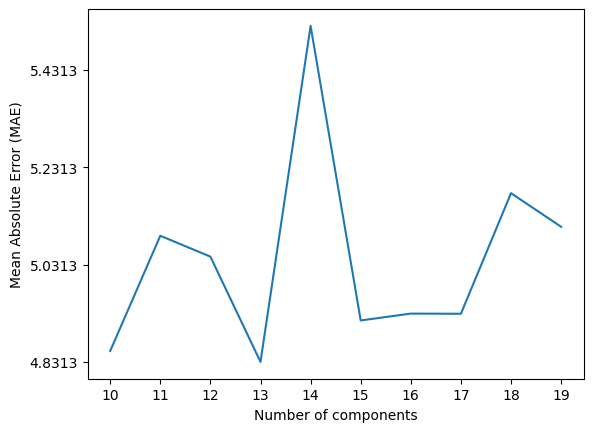

In [23]:
for n in loopresults.keys():
  print(f"N = {n} - MAE = {loopresults[n]['mae']}")

values = [loopresults[n]["mae"] for n in RANGE_OF_DIMENSION]
plt.plot(RANGE_OF_DIMENSION, values)
plt.xticks(RANGE_OF_DIMENSION)
plt.xlabel("Number of components")
plt.yticks(np.arange(min(values), max(values) + 0.1, 0.2))
plt.ylabel("Mean Absolute Error (MAE)")
plt.show()

best_mae = 1000
best_num_of_components = 0
best_encoded_data = None
best_evaluation_data = None
for n in loopresults.keys():
  if loopresults[n]["mae"] < best_mae:
    best_num_of_components = n
    best_mae = loopresults[n]["mae"]
    best_encoded_data = loopresults[n]["encoded_data"]
    best_evaluation_data = loopresults[n]["evaluation_data"]

evaluation_board['dim_reduction_method'] += ["LSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]

inv_y_pred.shape = (198, 1)
inv_y_test.shape = (198, 1)


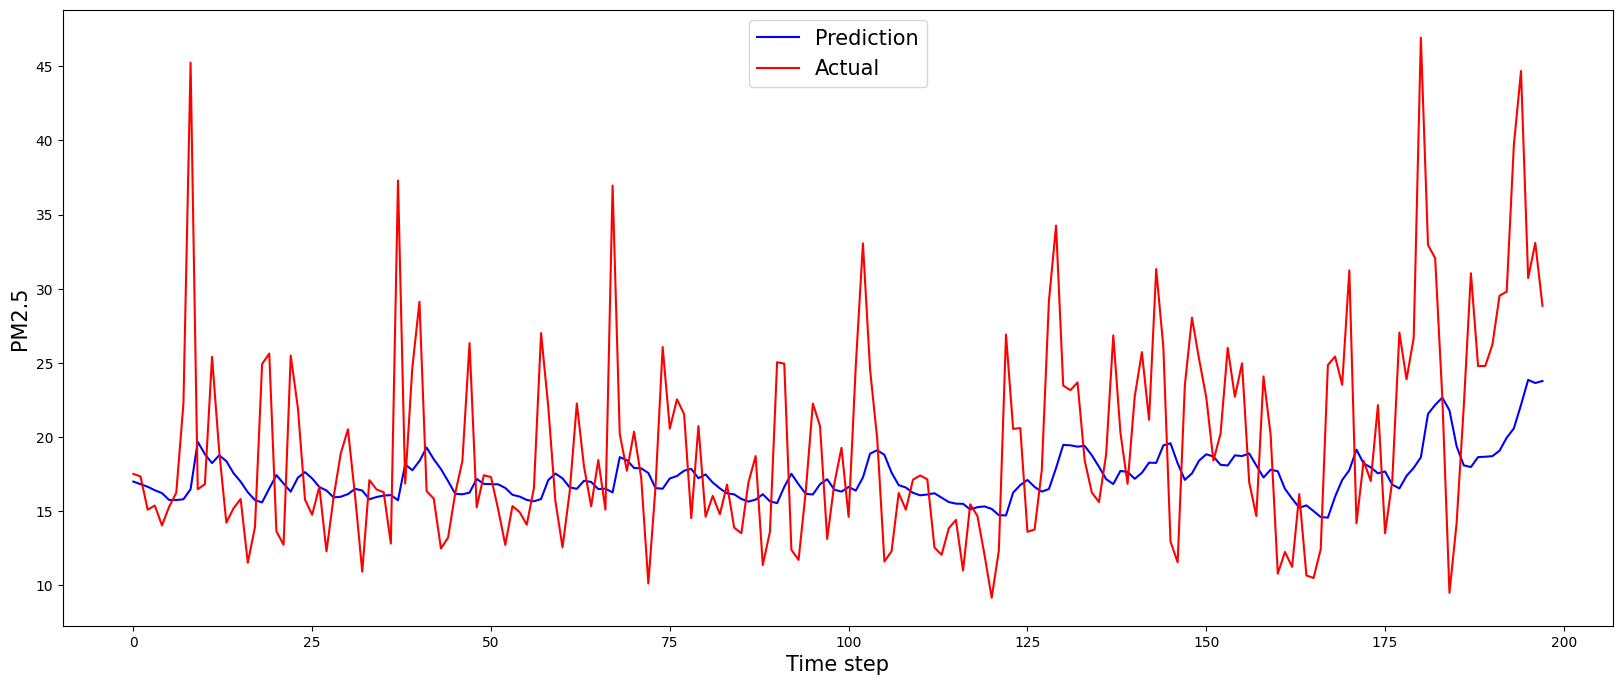

In [24]:
all_days_inv_y_pred, all_days_inv_y_test, _, _ = best_evaluation_data
for day in range(conf["prediction"]["n_future"]):
  inv_y_pred = all_days_inv_y_pred[day,:,:]
  inv_y_test = all_days_inv_y_test[day,:,:]
  print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")
  plot_2_data(data1=inv_y_pred,
              data2=inv_y_test,
              datalabel1="Prediction",
              datalabel2="Actual",
              xlabel="Time step",
              ylabel="PM2.5")

In [25]:
df_evaluation_board = pd.DataFrame(evaluation_board)
df_evaluation_board

,dim_reduction_method,dim_after_reduction,prediction,mae
0,LSTM-Seq2Seq,13,LSTM,4.831266


### Prediction + GRU-Seq2Seq

#### Doing the loop

In [ ]:
loopresults = {i:{"mae": None, "encoded_data": None, "evaluation_data": None} for i in RANGE_OF_DIMENSION}

# Loop between min and (number of features - 1) to choose what number is the best
for n in RANGE_OF_DIMENSION:
    # Apply Seq2seq
    grus2s = GRUSeq2SeqReduction(X_aod_scaled,
                                 test_percentage=0.2,
                                 latent_dim=n,
                                 n_past=conf["reduction"]["n_past"], n_future = conf["reduction"]["n_future"],
                                 epochs=conf["reduction"]["epochs"], batch_size=conf["reduction"]["batch_size"],
                                 verbose=0,
                                 model_name=f"aod_grus2s_dim_reduction_{n}_features")
    X_aod_scaled_gru_s2s_encoded = grus2s.execute()

    grus2s.get_model_info()
    grus2s.get_encoder_model_info()

    # Prediction
    y_pred, y_test = predictLSTM(X_aod_scaled_gru_s2s_encoded, y_aod_scaled,
                               n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                               epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                               model_name=f"aod_lstm_grus2s_dim_reduction_{n}_features",
                               verbose=0)
  
    # Evaluation
    all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae = evaluateLSTM(y_pred, y_test, aod_label_scaler, verbose=0)
  
    # Logging
    print(f"N = {n} - MAE = {avg_mae}")
    loopresults[n]["mae"] = avg_mae
    loopresults[n]["encoded_data"] = X_aod_scaled_gru_s2s_encoded
    loopresults[n]["evaluation_data"] = (all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae)

In [ ]:
for n in loopresults.keys():
  print(f"N = {n} - MAE = {loopresults[n]['mae']}")

values = [loopresults[n]["mae"] for n in RANGE_OF_DIMENSION]
plt.plot(RANGE_OF_DIMENSION, values)
plt.xticks(RANGE_OF_DIMENSION)
plt.xlabel("Number of components")
plt.yticks(np.arange(min(values), max(values) + 0.1, 0.1))
plt.ylabel("Mean Absolute Error (MAE)")
plt.show()

best_mae = 1000
best_num_of_components = 0
best_encoded_data = None
best_evaluation_data = None
for n in loopresults.keys():
    if loopresults[n]["mae"] < best_mae:
        best_num_of_components = n
        best_mae = loopresults[n]["mae"]
        best_encoded_data = loopresults[n]["encoded_data"]
        best_evaluation_data = loopresults[n]["evaluation_data"]

evaluation_board['dim_reduction_method'] += ["GRU-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]

In [ ]:
all_days_inv_y_pred, all_days_inv_y_test, _, _ = best_evaluation_data
for day in range(aod_LSTM_N_FUTURE):
    inv_y_pred = all_days_inv_y_pred[day,:,:]
    inv_y_test = all_days_inv_y_test[day,:,:]
    print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")
    plot_2_data(data1=inv_y_pred,
          data2=inv_y_test,
          datalabel1="Prediction",
          datalabel2="Actual",
          xlabel="Time step",
          ylabel="PM2.5")

In [ ]:
df_evaluation_board = pd.DataFrame(evaluation_board)
df_evaluation_board

### Prediction + CNN-LSTM Seq2seq

#### Doing the loop

In [ ]:
loopresults = {i:{"mae": None, "encoded_data": None, "evaluation_data": None} for i in RANGE_OF_DIMENSION}

# Loop between min and (number of features - 1) to choose what number is the best
for n in RANGE_OF_DIMENSION:
    # Apply Seq2seq
    cnnlstms2s = CNNLSTMSeq2SeqReduction(X_aod_scaled,
                                       test_percentage=0.2,
                                       latent_dim=n,
                                       n_past=conf["reduction"]["n_past"], n_future=conf["reduction"]["n_future"],
                                       epochs=conf["reduction"]["epochs"], batch_size=conf["reduction"]["batch_size"],
                                       verbose=0)
    
    X_aod_scaled_cnnlstm_s2s_encoded = cnnlstms2s.execute()
    
    cnnlstms2s.get_model_info()
    cnnlstms2s.get_encoder_model_info()
    
    # Prediction
    y_pred, y_test = predictLSTM(X_aod_scaled_cnnlstm_s2s_encoded, y_aod_scaled,
                                n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                                epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                                model_name=f"aod_lstm_cnnlstm_s2s_dim_reduction_{n}_features",
                                verbose=0)
    
    # Evaluation
    all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae = evaluateLSTM(y_pred, y_test, aod_label_scaler, verbose=0)
    
    # Logging
    loopresults[n]["mae"] = avg_mae
    loopresults[n]["encoded_data"] = X_aod_scaled_cnnlstm_s2s_encoded
    loopresults[n]["evaluation_data"] = (all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae)

In [ ]:
for n in loopresults.keys():
  print(f"N = {n} - MAE = {loopresults[n]['mae']}")

values = [loopresults[n]["mae"] for n in RANGE_OF_DIMENSION]
plt.plot(RANGE_OF_DIMENSION, values)
plt.xticks(RANGE_OF_DIMENSION)
plt.xlabel("Number of components")
plt.yticks(np.arange(min(values), max(values) + 0.1, 0.2))
plt.ylabel("Mean Absolute Error (MAE)")
plt.show()

best_mae = 1000
best_num_of_components = 0
best_encoded_data = None
best_evaluation_data = None
for n in loopresults.keys():
  if loopresults[n]["mae"] < best_mae:
    best_num_of_components = n
    best_mae = loopresults[n]["mae"]
    best_encoded_data = loopresults[n]["encoded_data"]
    best_evaluation_data = loopresults[n]["evaluation_data"]

evaluation_board['dim_reduction_method'] += ["CNN-LSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]

In [ ]:
all_days_inv_y_pred, all_days_inv_y_test, _, _ = best_evaluation_data
for day in range(aod_LSTM_N_FUTURE):
  inv_y_pred = all_days_inv_y_pred[day,:,:]
  inv_y_test = all_days_inv_y_test[day,:,:]
  print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")
  plot_2_data(data1=inv_y_pred,
              data2=inv_y_test,
              datalabel1="Prediction",
              datalabel2="Actual",
              xlabel="Time step",
              ylabel="PM2.5")

In [ ]:
df_evaluation_board = pd.DataFrame(evaluation_board)
df_evaluation_board